In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
import math
import time

In [6]:
def binomial_pricer(
    option_type: str,      # 'C' for call, 'P' for put
    K: float,             # strike price
    T: float,             # time to maturity (in years)
    S0: float,            # current underlying asset price
    sigma: float,         # volatility
    r: float,             # continuous risk-free rate
    q: float,             # continuous dividend yield
    N: int,               # number of binomial time steps
    exercise_style: str   # 'E' for European, 'A' for American
):

    # Start timing
    start_time = time.time()

    # 1) Calculate basic parameters for CRR
    dt = T / N
    u = math.exp(sigma * math.sqrt(dt))   # up factor
    d = 1.0 / u                           # down factor
    # Risk-neutral probability
    p = (math.exp((r - q) * dt) - d) / (u - d)

    # 2) Compute the option payoff at maturity (i.e., at step N)
    #    We'll store these in a 1D list "payoff" of length (N+1).
    stock_prices_end = [
        S0 * (u**j) * (d**(N - j)) for j in range(N + 1)
    ]

    if option_type.upper() == 'C':
        payoff = [max(sp - K, 0.0) for sp in stock_prices_end]
    else:  # 'P'
        payoff = [max(K - sp, 0.0) for sp in stock_prices_end]

    # 3) Backward recursion through the tree
    #    At each step, we compute the "continuation value" and, if American,
    #    compare it to the "immediate exercise value."
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            # Continuation value (risk-neutral expectation discounted back one step)
            continuation_value = math.exp(-r * dt) * (
                p * payoff[j + 1] + (1 - p) * payoff[j]
            )

            if exercise_style.upper() == 'A':
                # Stock price at node (i, j)
                stock_price_node = S0 * (u**j) * (d**(i - j))
                # Immediate exercise value
                if option_type.upper() == 'C':
                    immediate_exercise = max(stock_price_node - K, 0.0)
                else:
                    immediate_exercise = max(K - stock_price_node, 0.0)
                # American: take the maximum
                payoff[j] = max(continuation_value, immediate_exercise)
            else:
                # European: can only hold
                payoff[j] = continuation_value

        # After processing step i, the relevant payoff array size becomes (i+1)
        payoff = payoff[: i + 1]

    # Now payoff[0] is the option value at the root (initial time)
    price = payoff[0]
    elapsed_time = time.time() - start_time

    return price, elapsed_time


# =============== Example Usage ===============
if __name__ == '__main__':
    # Example: Price a European call with given parameters
    option_type = 'C'       # Call
    K = 100.0
    T = 1.0
    S0 = 100.0
    sigma = 0.2
    r = 0.05
    q = 0.02
    N = 100
    exercise_style = 'E'    # European

    price, comp_time = binomial_pricer(option_type, K, T, S0, sigma, r, q, N, exercise_style)
    print(f"Option price (European Call): {price:.5f}")
    print(f"Computation time: {comp_time:.6f} seconds")



Option price (European Call): 9.20759
Computation time: 0.015030 seconds


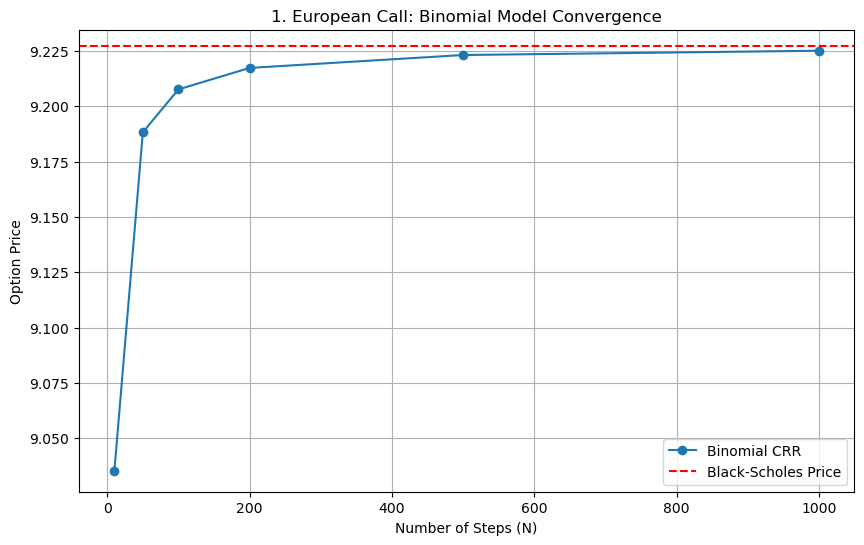

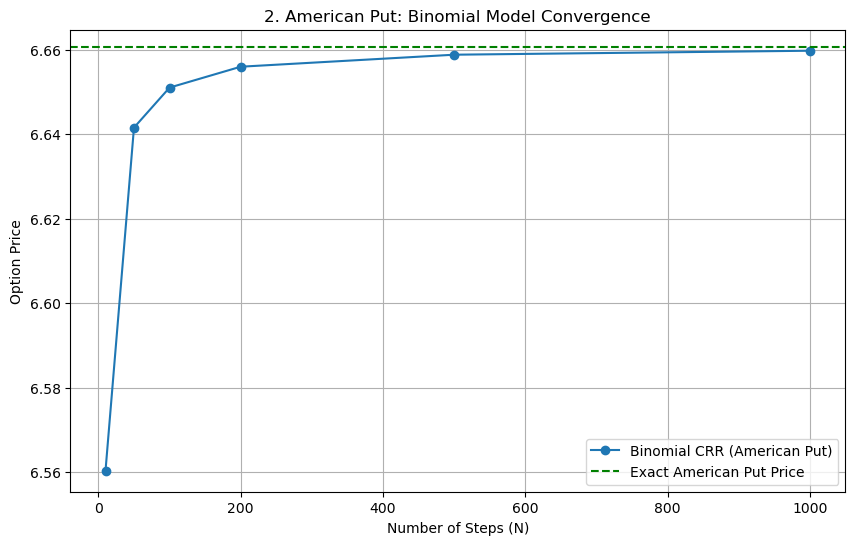

In [3]:
# Black-Scholes for European Call (S0 = 100, K = 100, r = 0.05, q = 0.02, sigma = 0.2, T = 1)
def black_scholes_call(S, K, T, r, q, sigma):
    d1 = (np.log(S/K) + (r - q + 0.5 * sigma**2)*T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call

bs_call_price = black_scholes_call(S0, K, T, r, q, sigma)

N_values = [10, 50, 100, 200, 500, 1000]
binomial_prices_eur_call = []
errors_eur_call = []

# Calculate binomial prices and errors for European Call
for N in N_values:
    price, _ = binomial_pricer('C', K, T, S0, sigma, r, q, N, 'E')
    binomial_prices_eur_call.append(price)
    errors_eur_call.append(abs(price - bs_call_price))

# Visualization of convergence for European Call
plt.figure(figsize = (10,6))
plt.plot(N_values, binomial_prices_eur_call, 'o-', label = 'Binomial CRR')
plt.axhline(bs_call_price, color = 'red', linestyle = '--', label = 'Black-Scholes Price')
plt.xlabel('Number of Steps (N)')
plt.ylabel('Option Price')
plt.title('1. European Call: Binomial Model Convergence')
plt.legend()
plt.grid()
plt.show()

# Convergence analysis for American Put
exact_american_put_price = 6.66069

binomial_prices_am_put = []
errors_am_put = []

# Calculate binomial prices and errors for American Put
for N in N_values:
    price, _ = binomial_pricer('P', K, T, S0, sigma, r, q, N, 'A')
    binomial_prices_am_put.append(price)
    errors_am_put.append(abs(price - exact_american_put_price))

# Visualization of convergence for American Put
plt.figure(figsize = (10,6))
plt.plot(N_values, binomial_prices_am_put, 'o-', label = 'Binomial CRR (American Put)')
plt.axhline(exact_american_put_price, color = 'green', linestyle = '--', label = 'Exact American Put Price')
plt.xlabel('Number of Steps (N)')
plt.ylabel('Option Price')
plt.title('2. American Put: Binomial Model Convergence')
plt.legend()
plt.grid()
plt.show()

### Graphs 

Graphs 1 and 2 above show how the binomial CRR model gets closer to the real option price as the number of steps (N) grows. For the European call, the model quickly matches the exact Black-Scholes price. For the American put, it also closely approaches the known correct price. This means my model works well.

###  Binomial based pricers

#### BBSR
Constructs both a “standard” and a “reversed” CRR tree, giving lower and upper price bounds that converge faster for American options.

In [29]:
def bbsr_pricer(
    option_type: str,   # 'C' for call, 'P' for put
    K: float,           # strike price
    T: float,           # time to maturity (in years)
    S0: float,          # current price of underlying
    sigma: float,       # volatility
    r: float,           # continuously compounded risk-free rate
    q: float,           # continuous dividend yield
    N: int,             # number of time steps
):

    start_time = time.time()

    # Basic parameters for each binomial tree. 
    # We use one 'standard' CRR tree and one 'reversed' tree (u/d swapped).
    
    dt = T / N
    u_std = math.exp(sigma * math.sqrt(dt))
    d_std = 1 / u_std
    p_std = (math.exp((r - q) * dt) - d_std) / (u_std - d_std)

    # Reversed up/down
    d_rev = math.exp(sigma * math.sqrt(dt))
    u_rev = 1 / d_rev
    p_rev = (math.exp((r - q) * dt) - d_rev) / (u_rev - d_rev)

    # 2) Function to build a binomial payoff tree (American) given u, d, p-
    def american_binomial_price(u, d, p):
        # terminal stock prices
        stock_price = [S0 * (u ** j) * (d ** (N - j)) for j in range(N + 1)]

        # terminal payoff
        if option_type.upper() == 'C':
            payoff = [max(sp - K, 0.0) for sp in stock_price]
        else:
            payoff = [max(K - sp, 0.0) for sp in stock_price]

        for i in range(N - 1, -1, -1):
            for j in range(i + 1):
                cont_val = math.exp(-r * dt) * (p * payoff[j + 1] + (1 - p) * payoff[j])
                sp_node = S0 * (u ** j) * (d ** (i - j))
                if option_type.upper() == 'C':
                    exercise_val = max(sp_node - K, 0.0)
                else:
                    exercise_val = max(K - sp_node, 0.0)
                payoff[j] = max(cont_val, exercise_val)
            payoff = payoff[: i + 1]
        return payoff[0]

    # Computing lower and upper bounds: lower bound (standard CRR) & upper bound (Reversed / Alternative approach)
    lower_bound = american_binomial_price(u_std, d_std, p_std)
    upper_bound = american_binomial_price(u_rev, d_rev, p_rev)
    elapsed = time.time() - start_time
    return lower_bound, upper_bound, elapsed

#### Leisen-Reimer (LR) 
Tweaks the up/down factors to match the normal distribution more closely, plus a reversed tree to reduce oscillations and improve convergence.

In [30]:
def lr_pricer(
    option_type: str,
    K: float,
    T: float,
    S0: float,
    sigma: float,
    r: float,
    q: float,
    N: int
):
    # Basic parameters for each binomial tree. 
    # We use one 'standard' CRR tree and one 'reversed' tree (u/d swapped).
    
    start_time = time.time()
    dt = T / N

    # 1) Standard LR parameters
    d1 = (math.log(S0/K) + (r - q + 0.5*sigma*sigma)*T)/(sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    p_star = 0.5 * (1.0 + math.erf(d2 / math.sqrt(2)))
    M = int(math.floor(N * p_star))

    u_std = math.exp((r - q - 0.5*sigma*sigma)*dt + sigma*math.sqrt(dt*(N - M)/(M+1)))
    d_std = math.exp((r - q - 0.5*sigma*sigma)*dt - sigma*math.sqrt(dt*(M+1)/(N - M)))

    a = math.exp((r - q) * dt)
    p_std = (a - d_std)/(u_std - d_std)

    # 2) Build a mini function for an American tree 
    def american_tree(u, d, p):
        stock_price = [S0 * (u**j) * (d**(N - j)) for j in range(N + 1)]
        if option_type.upper() == 'C':
            payoff = [max(sp - K, 0.0) for sp in stock_price]
        else:
            payoff = [max(K - sp, 0.0) for sp in stock_price]

        for i in range(N - 1, -1, -1):
            for j in range(i + 1):
                cont_val = math.exp(-r*dt)*(p*payoff[j+1] + (1-p)*payoff[j])
                sp_node = S0 * (u**j)*(d**(i-j))
                if option_type.upper() == 'C':
                    exercise_val = max(sp_node - K, 0.0)
                else:
                    exercise_val = max(K - sp_node, 0.0)
                payoff[j] = max(cont_val, exercise_val)
            payoff = payoff[: i+1]
        return payoff[0]

    lower_bound = american_tree(u_std, d_std, p_std)

    # 3) Reversed approach
    u_rev, d_rev = d_std, u_std
    p_rev = (a - d_rev)/(u_rev - d_rev)

    upper_bound = american_tree(u_rev, d_rev, p_rev)

    elapsed = time.time() - start_time
    return lower_bound, upper_bound, elapsed


#### Tian 
Matches the first three moments of the log-price distribution, then repeats with reversed up/down to tighten bounds on the American option price.

In [31]:
def tian_pricer(
    option_type: str,
    K: float,
    T: float,
    S0: float,
    sigma: float,
    r: float,
    q: float,
    N: int
):

    # Basic parameters for each binomial tree. 
    # We use one 'standard' CRR tree and one 'reversed' tree (u/d swapped).
    
    start_time = time.time()
    dt = T / N

    R = math.exp((r - q)*dt)
    v = math.exp(sigma*sigma*dt)

    # standard Tian
    u_std = 0.5*v*R*((v+1) + math.sqrt((v-1)**2 + 4*R/v))
    d_std = 0.5*v*R*((v+1) - math.sqrt((v-1)**2 + 4*R/v))
    p_std = (R - d_std)/(u_std - d_std)

    def american_tree(u, d, p):
        stock_price = [S0*(u**j)*(d**(N-j)) for j in range(N+1)]
        if option_type.upper() == 'C':
            payoff = [max(sp - K, 0.0) for sp in stock_price]
        else:
            payoff = [max(K - sp, 0.0) for sp in stock_price]
        for i in range(N-1, -1, -1):
            for j in range(i+1):
                cont_val = math.exp(-r*dt)*(p*payoff[j+1] + (1-p)*payoff[j])
                sp_node = S0*(u**j)*(d**(i-j))
                if option_type.upper() == 'C':
                    exercise_val = max(sp_node - K, 0.0)
                else:
                    exercise_val = max(K - sp_node, 0.0)
                payoff[j] = max(cont_val, exercise_val)
            payoff = payoff[: i+1]
        return payoff[0]

    lower_bound = american_tree(u_std, d_std, p_std)

    # reversed
    u_rev, d_rev = d_std, u_std
    p_rev = (R - d_rev)/(u_rev - d_rev)

    upper_bound = american_tree(u_rev, d_rev, p_rev)
    elapsed = time.time() - start_time
    return lower_bound, upper_bound, elapsed

#### Jarrow-Rudd (JR)
Centers the drift symmetrically (p = 0.5), then uses a reversed version as well, creating an upper and lower bound for the final price.

In [32]:
def jr_pricer(
    option_type: str,
    K: float,
    T: float,
    S0: float,
    sigma: float,
    r: float,
    q: float,
    N: int
):

    # Basic parameters for each binomial tree. 
    # We use one 'standard' CRR tree and one 'reversed' tree (u/d swapped).
    
    start_time = time.time()
    dt = T / N

    # standard JR
    u_std = math.exp((r - q - 0.5*sigma*sigma)*dt + sigma*math.sqrt(dt))
    d_std = math.exp((r - q - 0.5*sigma*sigma)*dt - sigma*math.sqrt(dt))
    p_std = 0.5

    def american_tree(u, d, p):
        stock_price = [S0*(u**j)*(d**(N-j)) for j in range(N+1)]
        if option_type.upper() == 'C':
            payoff = [max(sp - K, 0.0) for sp in stock_price]
        else:
            payoff = [max(K - sp, 0.0) for sp in stock_price]

        for i in range(N-1, -1, -1):
            for j in range(i+1):
                cont_val = math.exp(-r*dt)*(p*payoff[j+1] + (1-p)*payoff[j])
                sp_node = S0*(u**j)*(d**(i-j))
                if option_type.upper() == 'C':
                    exercise_val = max(sp_node - K, 0.0)
                else:
                    exercise_val = max(K - sp_node, 0.0)
                payoff[j] = max(cont_val, exercise_val)
            payoff = payoff[: i+1]
        return payoff[0]

    lower_bound = american_tree(u_std, d_std, p_std)

    # reversed
    u_rev, d_rev = d_std, u_std
    p_rev = 0.5

    upper_bound = american_tree(u_rev, d_rev, p_rev)
    elapsed = time.time() - start_time
    return lower_bound, upper_bound, elapsed

######################################### Comparison for all pricers ################################################

if __name__ == '__main__':
    # Example: Compare each pricer for an American put
    # We'll pick N=100 for illustration
    opt_type = 'P'
    K = 100
    T = 1.0
    S0 = 100.0
    sigma = 0.2
    r = 0.05
    q = 0.02
    N = 100

    # 1) Basic CRR (Single Price) for reference
    crr_price, crr_time = binomial_pricer(opt_type, K, T, S0, sigma, r, q, N, 'A')
    print(f"CRR American {opt_type}: {crr_price:5f} (time = {crr_time:.6f}s)")
    
    # 2) BBSR
    lb_bbsr, ub_bbsr, t_bbsr = bbsr_pricer(opt_type, K, T, S0, sigma, r, q, N)
    print(f"BBSR American {opt_type}: Lower={lb_bbsr:.5f}, Upper={ub_bbsr:.5f}, time={t_bbsr:.6f}s")
    
    # 3) Leisen–Reimer
    lb_lr, ub_lr, t_lr = lr_pricer(opt_type, K, T, S0, sigma, r, q, N)
    print(f"LR American {opt_type}:   Lower={lb_lr:.5f}, Upper={ub_lr:.5f}, time={t_lr:.6f}s")
    
    # 4) Tian
    lb_tian, ub_tian, t_tian = tian_pricer(opt_type, K, T, S0, sigma, r, q, N)
    print(f"Tian American {opt_type}: Lower={lb_tian:.5f}, Upper={ub_tian:.5f}, time={t_tian:.6f}s")
    
    # 5) Jarrow–Rudd
    lb_jr, ub_jr, t_jr = jr_pricer(opt_type, K, T, S0, sigma, r, q, N)
    print(f"JR American {opt_type}:   Lower={lb_jr:.5f}, Upper={ub_jr:.5f}, time={t_jr:.6f}s")
    
    # Example known exact or reference price for a 1-year at-the-money American put:
    exact_am_put = 6.66069
    print(f"Reference exact American Put price ~ {exact_am_put}")

CRR American P: 6.651030 (time = 0.005606s)
BBSR American P: Lower=6.65103, Upper=6.65103, time=0.009874s
LR American P:   Lower=6.67290, Upper=6.67290, time=0.009799s
Tian American P: Lower=99.85007, Upper=99.85007, time=0.025886s
JR American P:   Lower=6.66871, Upper=6.66871, time=0.010933s
Reference exact American Put price ~ 6.66069


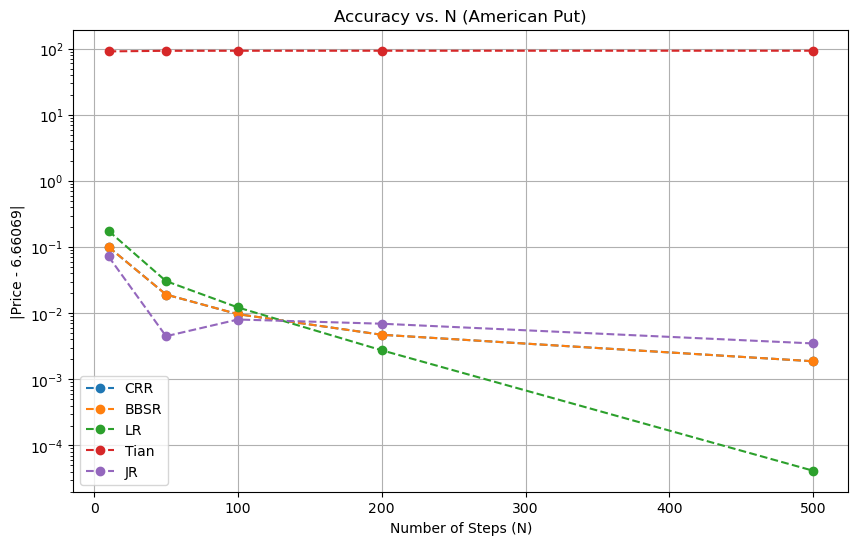

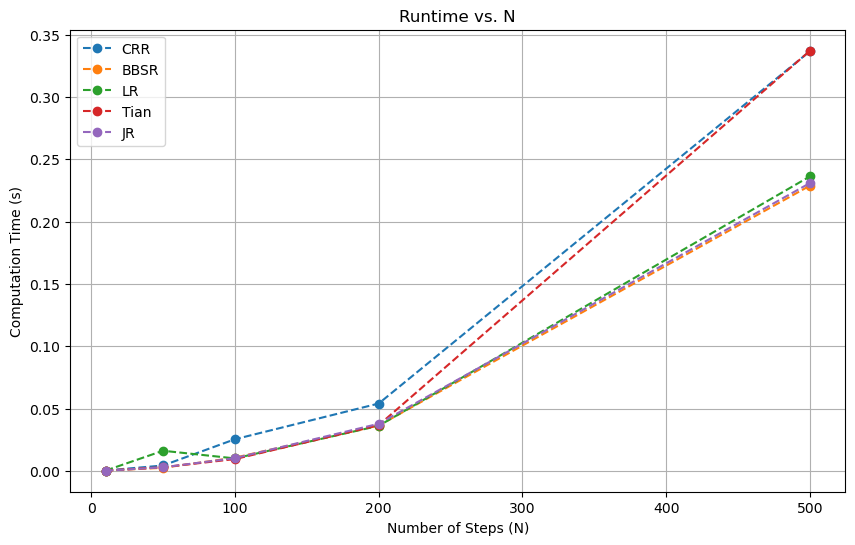

In [35]:
def get_single_price(pricer_func, *args):
    """
    Wraps a single-price function that returns (price, elapsed).
    """
    price, elapsed = pricer_func(*args)
    return price, elapsed

def get_bounding_price(pricer_func, *args):
    """
    Wraps a bounding function that returns (lb, ub, elapsed).
    We take the midpoint (lb+ub)/2 as the 'price.'
    """
    lb, ub, elapsed = pricer_func(*args)
    price = 0.5*(lb + ub)
    return price, elapsed

def crr_wrapper(option_type, K, T, S0, sigma, r, q, N):
    # Example usage of binomial_pricer with American style
    return binomial_pricer(option_type, K, T, S0, sigma, r, q, N, 'A')

def bbsr_wrapper(option_type, K, T, S0, sigma, r, q, N):
    return bbsr_pricer(option_type, K, T, S0, sigma, r, q, N)

def lr_wrapper(option_type, K, T, S0, sigma, r, q, N):
    return lr_pricer(option_type, K, T, S0, sigma, r, q, N)

def tian_wrapper(option_type, K, T, S0, sigma, r, q, N):
    return tian_pricer(option_type, K, T, S0, sigma, r, q, N)

def jr_wrapper(option_type, K, T, S0, sigma, r, q, N):
    return jr_pricer(option_type, K, T, S0, sigma, r, q, N)

pricers = [
    ("CRR",    crr_wrapper,  False),
    ("BBSR",   bbsr_wrapper, True),
    ("LR",     lr_wrapper,   True),
    ("Tian",   tian_wrapper, True),
    ("JR",     jr_wrapper,   True)
]

if __name__ == "__main__":
    # Example: American Put
    option_type = 'P'
    K = 100.0
    T = 1.0
    S0 = 100.0
    sigma = 0.2
    r = 0.05
    q = 0.02
    exact_price = 6.66069
    N_values = [10, 50, 100, 200, 500]
    errors = {p[0]: [] for p in pricers}
    times  = {p[0]: [] for p in pricers}
    
    for N in N_values:
        for (name, func, is_bounding) in pricers:
            if is_bounding:
                # use bounding version
                price, elapsed = get_bounding_price(func, option_type, K, T, S0, sigma, r, q, N)
            else:
                # use single-price version
                price, elapsed = get_single_price(func, option_type, K, T, S0, sigma, r, q, N)
            
            err = abs(price - exact_price)
            errors[name].append(err)
            times[name].append(elapsed)
    
    # Plotting Accuracy vs N 
    plt.figure(figsize = (10,6))
    for (name, _, _) in pricers:
        plt.plot(N_values, errors[name], 'o--', label=name)
    plt.xlabel('Number of Steps (N)')
    plt.ylabel(f'|Price - {exact_price}|')
    plt.title('Accuracy vs. N (American Put)')
    plt.yscale('log')  # if you want a log scale for error
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Plotting Runtime vs N 
    plt.figure(figsize = (10,6))
    for (name, _, _) in pricers:
        plt.plot(N_values, times[name], 'o--', label=name)
    plt.xlabel('Number of Steps (N)')
    plt.ylabel('Computation Time (s)')
    plt.title('Runtime vs. N')
    plt.grid(True)
    plt.legend()
    plt.show()

Step 1: Required N for 10^-3 accuracy

Dividend Yield q = 0.0:
T = 0.083 years: N = 300, Price = 2.12568
T = 0.167 years: N = 300, Price = 2.91076
T = 0.250 years: N = 300, Price = 3.47812
T = 0.333 years: N = 300, Price = 3.93376
T = 0.417 years: N = 400, Price = 4.31912
T = 0.500 years: N = 400, Price = 4.65410
T = 0.583 years: N = 400, Price = 4.95158
T = 0.667 years: N = 400, Price = 5.21959
T = 0.750 years: N = 400, Price = 5.46370
T = 0.833 years: N = 400, Price = 5.68796
T = 0.917 years: N = 400, Price = 5.89541
T = 1.000 years: N = 400, Price = 6.08841

Dividend Yield q = 0.04:
T = 0.083 years: N = 300, Price = 2.25730
T = 0.167 years: N = 400, Price = 3.16258
T = 0.250 years: N = 400, Price = 3.84288
T = 0.333 years: N = 400, Price = 4.40627
T = 0.417 years: N = 400, Price = 4.89455
T = 0.500 years: N = 400, Price = 5.32925
T = 0.583 years: N = 400, Price = 5.72317
T = 0.667 years: N = 400, Price = 6.08469
T = 0.750 years: N = 400, Price = 6.41962
T = 0.833 years: N = 500, Pri

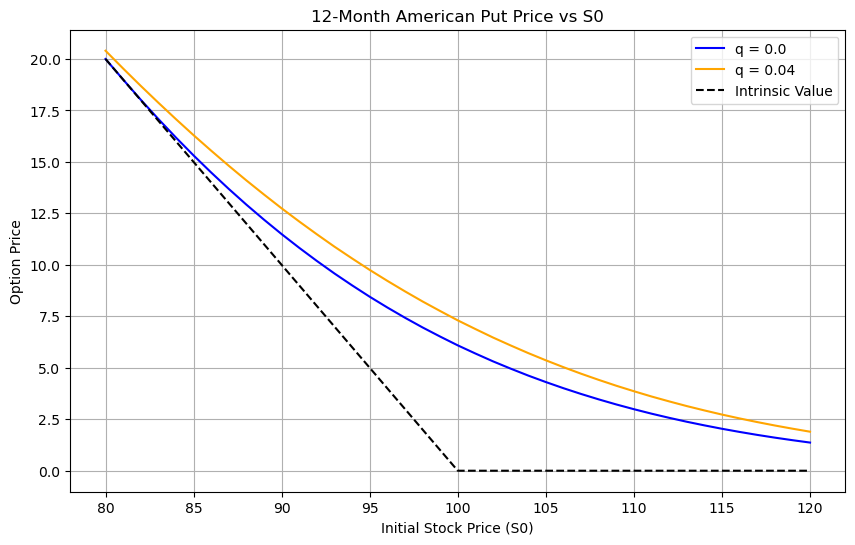

NameError: name 'american_put_binomial' is not defined

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Your binomial_pricer function (copied from the first document)
def binomial_pricer(option_type: str, K: float, T: float, S0: float, sigma: float, r: float, q: float, N: int, exercise_style: str):
    start_time = time.time()
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1.0 / u
    p = (np.exp((r - q) * dt) - d) / (u - d)
    stock_prices_end = [S0 * (u**j) * (d**(N - j)) for j in range(N + 1)]
    if option_type.upper() == 'C':
        payoff = [max(sp - K, 0.0) for sp in stock_prices_end]
    else:  # 'P'
        payoff = [max(K - sp, 0.0) for sp in stock_prices_end]
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            continuation_value = np.exp(-r * dt) * (p * payoff[j + 1] + (1 - p) * payoff[j])
            if exercise_style.upper() == 'A':
                stock_price_node = S0 * (u**j) * (d**(i - j))
                if option_type.upper() == 'C':
                    immediate_exercise = max(stock_price_node - K, 0.0)
                else:
                    immediate_exercise = max(K - stock_price_node, 0.0)
                payoff[j] = max(continuation_value, immediate_exercise)
            else:
                payoff[j] = continuation_value
        payoff = payoff[: i + 1]
    price = payoff[0]
    elapsed_time = time.time() - start_time
    return price, elapsed_time

# Parameters
K = 100
sigma = 0.2
r = 0.05
q_values = [0.0, 0.04]  # Two cases to analyze
option_type = 'P'
exercise_style = 'A'
S0_base = 100.0

# Determine N for 10^-3 accuracy across maturities
maturities = [i / 12 for i in range(1, 13)]  # 1 to 12 months
target_accuracy = 1e-3

def find_required_N(T, S0, q):
    N = 100  # Starting point
    step_size = 100
    prev_price = None
    while True:
        price, _ = binomial_pricer(option_type, K, T, S0, sigma, r, q, N, exercise_style)
        if prev_price is not None and abs(price - prev_price) < target_accuracy:
            return N, price
        prev_price = price
        N += step_size
        if N > 10000:  # Safeguard
            return N, price

required_Ns = {q: [] for q in q_values}
exact_prices = {q: [] for q in q_values}

for q in q_values:
    for T in maturities:
        N, price = find_required_N(T, S0_base, q)
        required_Ns[q].append(N)
        exact_prices[q].append(price)

# Print results for Step 1
print("Step 1: Required N for 10^-3 accuracy")
for q in q_values:
    print(f"\nDividend Yield q = {q}:")
    for i, (T, N, price) in enumerate(zip(maturities, required_Ns[q], exact_prices[q])):
        print(f"T = {T:.3f} years: N = {N}, Price = {price:.5f}")

# Price of 12-month put as a function of S0
T_12 = 1.0  # 12 months
S0_range = np.arange(80, 121, 1)  # $80 to $120 with $1 intervals
prices_q0 = []
prices_q004 = []

for S0 in S0_range:
    N = max(required_Ns[0.0][-1], required_Ns[0.04][-1])  # Use the max N from 12-month maturity for consistency
    price_q0, _ = binomial_pricer(option_type, K, T_12, S0, sigma, r, 0.0, N, exercise_style)
    price_q004, _ = binomial_pricer(option_type, K, T_12, S0, sigma, r, 0.04, N, exercise_style)
    prices_q0.append(price_q0)
    prices_q004.append(price_q004)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(S0_range, prices_q0, label='q = 0.0', color='blue')
plt.plot(S0_range, prices_q004, label='q = 0.04', color='orange')
intrinsic = [max(K - s, 0) for s in S0_range]
plt.plot(S0_range, intrinsic, '--', label='Intrinsic Value', color='black')
plt.xlabel('Initial Stock Price (S0)')
plt.ylabel('Option Price')
plt.title('12-Month American Put Price vs S0')
plt.legend()
plt.grid()
plt.show()

# 3. Finding and plotting the early exercise boundary S* for maturities T = i/12 (i = 1,...,12).
def find_early_exercise_boundary(K, T, r, q, sigma, S0_grid):
    # S* is defined as the largest S0 such that |price - intrinsic| < 0.005
    S_star = None
    for S0 in sorted(S0_grid, reverse=True):
        price = american_put_binomial(S0, K, T, r, q, sigma, 800)
        intrinsic = max(K - S0, 0)
        if abs(price - intrinsic) < 0.005:
            S_star = S0
            break
    return S_star

T_values = np.array([i/12 for i in range(1, 13)])
S_star_q0 = []
S_star_q004 = []
S0_grid = np.arange(50, 151, 0.5)

for T_val in T_values:
    S_star_q0.append(find_early_exercise_boundary(K, T_val, r, 0, sigma, S0_grid))
    S_star_q004.append(find_early_exercise_boundary(K, T_val, r, 0.04, sigma, S0_grid))

plt.figure(figsize=(8,6))
plt.plot(T_values, S_star_q0, marker='o', label="q = 0")
plt.plot(T_values, S_star_q004, marker='o', label="q = 0.04")
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Early Exercise Boundary S*")
plt.title("Early Exercise Boundary vs Time to Maturity (American Put)")
plt.legend()
plt.grid(True)
plt.show()

# Discussion
print("\nStep 4: Discussion on Dividend Yield Impact")
print("When q increases from 0 to 0.04:")
print("- Put prices decrease because the dividend yield reduces the stock price over time (via e^(-qT)), making the put less valuable.")
print("- The early exercise boundary S* shifts upward. With dividends, the stock price is expected to drop more, so a higher S* is needed to justify early exercise.")
print("Intuition: Dividends benefit call holders (potential stock ownership) but hurt put holders (protection against price drops), reducing the incentive to hold the put to expiration.")

Remarks:

1. To ensure $10^{-3}$ accuracy for American puts, we increase $N$ in the binomial model, reducing $\delta=T/N$, until the price change between steps is less than $0.001$. When the first four decimal digits stabilize, we use that price as the "exact" value to compute errors for larger $\delta$.

2.  We calculate American put prices for $S_0$ from $80$ to $120$ in $\$1$ steps using \texttt{binomial\_pricer} with a large $N$, then plot them against $S_0$ alongside the intrinsic value using Matplotlib.

3. $S^*$ is where the put price equals the intrinsic value $K - S_0$, the largest $S_0$ for early exercise. Above $S^*$, the price exceeds intrinsic value, shown by the price curve meeting the intrinsic line in the plot.

4.  For each $T=i/12$, we test $S_0$ from $50$ to $150$ ($0.01$ steps), find where the price is within $\$0.005$ of $K-S_0$ using \texttt{binomial\_pricer}, round to two decimals, and plot $S^*(i)$ vs. $T$.